In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from random import shuffle
import os
import cv2
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm 
import seaborn as sns


np.set_printoptions(precision=5)#show 5 number after decimal point 

In [2]:
TRAIN_DIR = r"C:\Users\noa12\OneDrive\מסמכים\GitHub\Dogs_Vs_Cats_Project\train"
imgSize = 50

In [5]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return "0"
    elif word_label == 'dog': return "1"

In [6]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join("train\\",img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (imgSize,imgSize))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

```python
train_data = create_train_data()
``` 

In [7]:
# If you have already created the dataset:
train_data = np.load('train_data.npy',allow_pickle=True)

In [8]:
X = np.array([i[0] for i in train_data])
Y = np.array([i[1] for i in train_data])

In [9]:
from sklearn.model_selection import train_test_split
#split the data
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)

X_train = X_train / 255.0
X_test = X_test / 255.0

In [10]:
y_test

array(['0', '1', '0', ..., '1', '1', '1'], dtype='<U1')

In [11]:
print("X_train.shape :" ,X_train.shape)
print("y_train.shape :", y_train.shape)
print ("X_test.shape :" , X_test.shape)
print("y_test.shape :", y_test.shape)

X_train.shape : (22500, 50, 50)
y_train.shape : (22500,)
X_test.shape : (2500, 50, 50)
y_test.shape : (2500,)


In [12]:
X_train = X_train.reshape((22500, 50*50))
y_train = y_train.reshape((22500,1))
X_test = X_test.reshape((2500,50*50))
y_test = y_test.reshape((2500,1))

print("X_train.shape :" ,X_train.shape)
print("y_train.shape :", y_train.shape)
print ("X_test.shape :" , X_test.shape)
print("y_test.shape :", y_test.shape)

X_train.shape : (22500, 2500)
y_train.shape : (22500, 1)
X_test.shape : (2500, 2500)
y_test.shape : (2500, 1)


In [13]:
class_names = {0:"cat", 1:"dog"}

In [14]:
#check that the data is balanced
unique, counts = np.unique(y_train, return_counts=True)
print("y_train :", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("y_test :", dict(zip(unique, counts)))

y_train : {'0': 11261, '1': 11239}
y_test : {'0': 1239, '1': 1261}


In [15]:
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [16]:
# Before we try real models, we will try a dummyClassifier. we will try to get high score than the dummyModel.
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print("The DummyClassifier score is:" ,accuracy_score(y_pred,y_test))

The DummyClassifier score is: 0.4956


In [17]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred = RF.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
#print("Classification Report: \n", metrics.classification_report(y_test, y_pred))

Accuracy: 0.634


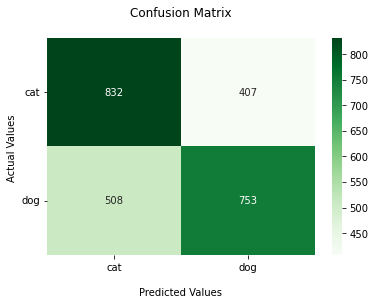

In [18]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Greens')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(["cat","dog"])
ax.yaxis.set_ticklabels(["cat","dog"],rotation=0)

plt.show()

In [ ]:
from xgboost import XGBClassifier

XGB = XGBClassifier()
XGB.fit(X_train, y_train,eval_metric='rmse')
y_pred = XGB.predict(X_test)

accuracy = round(metrics.accuracy_score(y_test, y_pred),3)
print("Accuracy:", accuracy)
#print("Classification Report: \n", metrics.classification_report(y_test, y_pred))

In [19]:
from sklearn.ensemble import AdaBoostClassifier

AdB = AdaBoostClassifier()
AdB.fit(X_train, y_train)
y_pred = AdB.predict(X_test)

accuracy = round(metrics.accuracy_score(y_test, y_pred),3)
print("Accuracy:", accuracy)
#print("Classification Report: \n", metrics.classification_report(y_test, y_pred))

Accuracy: 0.604


print('True:', y_test[0:15])
print('False:', y_pred[0:15])

In [16]:
#Searching for better performance out of the models with RandomizedSearch
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#XGBClassifier
parameters = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [int(x) for x in range(10, 200,10)],
         }
random_XGB = RandomizedSearchCV(XGBClassifier(),parameters, verbose=True, n_jobs=15, 
                          cv=2,scoring='accuracy',random_state=42, n_iter = 3)
random_XGB.fit(X_train,y_train)
y_pred_XGB_random = random_XGB.predict(X_test)
print ("Accuracy Score = ",metrics.accuracy_score(y_test,y_pred_XGB_random))
print (random_XGB.best_params_)